In [94]:
from kafka import KafkaConsumer
import pandas as pd
from json import dumps
import numpy as np
import pickle
from sklearn.metrics import classification_report,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

from pandas.util import hash_pandas_object
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

In [95]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

for m in consumer:
        x=m.value
        break 

In [96]:
x

b'"04:31.7,25,8,0,10,9,2.556641667,6,6,7,3.333333333,2,192,12,1,0\\n"'

In [97]:

def stream_1000_obs(itr):
    list_with_1000_record=[]
    i=0
    for m in consumer:
        
        if i <1000:
            list_with_1000_record.append(m.value)
            i=i+1
        else:
            
            break
    print(f"Window {itr}")
   
    
    return list_with_1000_record   

In [98]:
static_column_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def prepare(data):
    df=pd.DataFrame()
    rows=[]
    for line in data:
        row=eval(line.decode("utf-8"))
        row = row.strip()
        row= row.split(",")
        rows.append(row)
    df=pd.DataFrame(rows)
    df.columns=static_column_names
    return df

In [99]:
def Hashing_removena(data):
    data['timestamp']=hash_pandas_object(data['timestamp'])
    data['sld']=hash_pandas_object(data['sld'])
    data['longest_word']=hash_pandas_object(data['longest_word'])
    data=data.dropna()
    return data.astype('float')

In [107]:
static_dataset= pd.read_csv("Static_dataset.csv")
static_dataset['timestamp']=hash_pandas_object(static_dataset['timestamp'])
static_dataset['sld']=hash_pandas_object(static_dataset['sld'])
static_dataset['longest_word']=hash_pandas_object(static_dataset['longest_word'])
static_dataset.astype('float')


,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,1.314324e+19,27.0,10.0,0.0,10.0,11.0,2.570417,6.0,6.0,7.0,3.666667,1.281860e+19,1.436062e+18,14.0,1.0,1.0
1,2.577387e+18,27.0,10.0,0.0,10.0,11.0,2.767195,6.0,6.0,7.0,3.666667,1.718575e+19,1.648710e+19,14.0,1.0,1.0
2,2.195308e+17,26.0,9.0,0.0,10.0,10.0,2.742338,6.0,6.0,7.0,3.500000,1.797948e+19,8.782042e+18,13.0,1.0,0.0
3,2.202386e+18,27.0,10.0,0.0,10.0,11.0,2.570417,6.0,6.0,7.0,3.666667,8.625786e+18,1.421311e+19,14.0,1.0,1.0
4,1.360000e+19,15.0,9.0,0.0,11.0,0.0,2.929439,4.0,3.0,5.0,4.333333,6.933423e+18,6.933423e+18,15.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,4.635147e+18,18.0,3.0,0.0,16.0,0.0,2.338623,2.0,3.0,10.0,5.333333,1.759309e+19,1.074113e+18,14.0,1.0,0.0
268070,6.947247e+17,27.0,10.0,0.0,10.0,11.0,2.767195,6.0,6.0,7.0,3.666667,6.543177e+18,1.162920e+19,14.0,1.0,0.0
268071,1.307671e+19,27.0,10.0,0.0,10.0,11.0,2.767195,6.0,6.0,7.0,3.666667,1.392224e+18,1.121411e+19,14.0,1.0,1.0
268072,4.906493e+18,16.0,0.0,0.0,14.0,0.0,3.249687,2.0,2.0,13.0,7.500000,6.819429e+18,1.012213e+19,14.0,0.0,0.0


In [108]:
def retrain(data):
    pipeline_model = Pipeline(steps=[("scaler", StandardScaler()), ("mutual", SelectKBest(score_func=mutual_info_classif, k=7)), ("Decision Tree",  DecisionTreeClassifier())])
    X =data.drop(labels = ["Target Attack"], axis=1) 
    y=data["Target Attack"] 
    pipeline_model.fit(X,y)
    return pipeline_model

In [109]:
import pickle
static_model = Dynamic_model= pickle.load(open('Statical_model.pkl', 'rb'))
x=y=2

In [110]:
static_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('mutual',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_classif at 0x00000296EAC7FCA0>)),
                ('Decision Tree', DecisionTreeClassifier())])

In [111]:
Dynamic_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('mutual',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_classif at 0x00000296EAC7FCA0>)),
                ('Decision Tree', DecisionTreeClassifier())])

In [112]:
static_dataset=static_dataset.drop(labels = ["Target Attack"], axis=1)
static_dataset

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,13143242955146178578,27,10,0,10,11,2.570417,6,6,7,3.666667,12818595333635098865,1436061903013436886,14,1
1,2577386964918736430,27,10,0,10,11,2.767195,6,6,7,3.666667,17185745172638414508,16487103021445981531,14,1
2,219530798504705711,26,9,0,10,10,2.742338,6,6,7,3.500000,17979476933330425403,8782042356081258380,13,1
3,2202385798199089757,27,10,0,10,11,2.570417,6,6,7,3.666667,8625786489483146881,14213111700542671718,14,1
4,13599999059469247330,15,9,0,11,0,2.929439,4,3,5,4.333333,6933423371777200487,6933423371777200487,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268069,4635147120335315575,18,3,0,16,0,2.338623,2,3,10,5.333333,17593087732653107179,1074112825213617825,14,1
268070,694724741529077594,27,10,0,10,11,2.767195,6,6,7,3.666667,6543177446356295113,11629204487744685214,14,1
268071,13076708599487200848,27,10,0,10,11,2.767195,6,6,7,3.666667,1392224066739923824,11214114670944286487,14,1
268072,4906493388405613576,16,0,0,14,0,3.249687,2,2,13,7.500000,6819429491188426835,10122129679838215532,14,0


In [113]:
Dynmaic_model_acc=[]
static_model_acc=[]
for itr in range(267):
    streamed_data = stream_1000_obs(itr+1)
    pre_dataset =  prepare(streamed_data)
    new_dataset =  Hashing_removena(pre_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]
    static_dataset.append(new_dataset)
    new_dataset.append(static_dataset)
    
    Dynamic_prediction=Dynamic_model.predict(X)
    Dynamic_accuracy=accuracy_score(y,Dynamic_prediction)
    Dynamic_precision=precision_score(y,Dynamic_prediction)
    print(f"Accuracy of Dynamic Model without retrain = {Dynamic_accuracy*100}%")
    print(f"Percision of Dynamic Model without retrain = {Dynamic_precision*100}%")
    if Dynamic_accuracy < 0.81 :
        print("Training with new data ")
        Dynamic_model=retrain(new_dataset)
        Dynamic_prediction=Dynamic_model.predict(X)
        Dynamic_accuracy=accuracy_score(y,Dynamic_prediction)
        print(f"Accuracy of Dynamic Decision Tree Model after retrain = {Dynamic_accuracy*100}%")
    static_dataset= static_dataset.append(new_dataset)
    static_prediction=static_model.predict(X)
    static_accuracy=accuracy_score(y,static_prediction)
    print(f"Accuracy of Static Decision Tree = {static_accuracy*100}%")
    Dynmaic_model_acc.append(Dynamic_accuracy)
    static_model_acc.append(static_accuracy)
    print(f"{'_'*60}")
    
   

Window 1
Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 72.26890756302521%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.4%
Accuracy of Static Decision Tree = 80.10000000000001%
____________________________________________________________
Window 2
Accuracy of Dynamic Model without retrain = 79.0%
Percision of Dynamic Model without retrain = 73.66197183098592%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 3
Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 74.56258411843876%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.80000000000001%
____________________________________________________________
Window 4
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 74.89539748953975%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 5


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 74.19354838709677%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.69999999999999%
Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 6
Accuracy of Dynamic Model without retrain = 78.9%
Percision of Dynamic Model without retrain = 73.7550471063257%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.2%
Accuracy of Static Decision Tree = 80.10000000000001%
____________________________________________________________
Window 7


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 79.9%
Percision of Dynamic Model without retrain = 73.44173441734418%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 8
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 75.63249001331558%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.0%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Window 9
Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 75.19685039370079%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.69999999999999%
Accuracy of Static Decision Tree = 81.69999999999999%
____________________________________________________________
Window 10
Accuracy of Dynamic Model without retrain = 82.0%
Percision of Dynamic Model without retrain = 75.94086021505376%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 11


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 75.44097693351425%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 12
Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 75.74931880108991%
Accuracy of Static Decision Tree = 81.6%
____________________________________________________________
Window 13
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 73.806275579809%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 14


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 78.4%
Percision of Dynamic Model without retrain = 73.01808066759388%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.30000000000001%
Accuracy of Static Decision Tree = 80.2%
____________________________________________________________
Window 15
Accuracy of Dynamic Model without retrain = 83.7%
Percision of Dynamic Model without retrain = 77.89904502046384%
Accuracy of Static Decision Tree = 83.7%
____________________________________________________________
Window 16
Accuracy of Dynamic Model without retrain = 80.4%
Percision of Dynamic Model without retrain = 73.57723577235772%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)


Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 17
Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 73.33333333333333%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.10000000000001%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 80.0%
____________________________________________________________
Window 18
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 73.61111111111111%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 19
Accuracy of Dynamic Model without retrain = 80.80000000000001%
Percision of Dynamic Model without retrain = 75.16688918558077%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 20
Accuracy of Dynamic Model without retrain = 82.69999999999999%
Percision of Dynamic Model without retrain = 77.32095490716179%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 21
Accuracy of 

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 23
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 74.40559440559441%
Accuracy of Static Decision Tree = 81.8%
____________________________________________________________
Window 24


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 72.77701778385773%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 25
Accuracy of Dynamic Model without retrain = 79.2%
Percision of Dynamic Model without retrain = 74.85714285714286%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.39999999999999%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 26
Accuracy of Dynamic Model without retrain = 80.80000000000001%
Percision of Dynamic Model without retrain = 74.5578231292517%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 27
Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 75.7703081232493%
Accuracy of Static Decision Tree = 82.5%
____________________________________________________________
Window 28


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 72.92817679558011%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.5%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 29
Accuracy of Dynamic Model without retrain = 79.7%
Percision of Dynamic Model without retrain = 73.72764786795048%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 30


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 75.33333333333333%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 31
Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 73.20703653585927%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.30000000000001%
Accuracy of Static Decision Tree = 80.2%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)


Window 32
Accuracy of Dynamic Model without retrain = 79.9%
Percision of Dynamic Model without retrain = 73.12588401697313%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 33
Accuracy of Dynamic Model without retrain = 80.80000000000001%
Percision of Dynamic Model without retrain = 73.75366568914956%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Decision Tree Model after retrain = 81.89999999999999%
Accuracy of Static Decision Tree = 81.8%
____________________________________________________________
Window 34
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 75.14367816091954%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.39999999999999%
Accuracy of Static Decision Tree = 82.39999999999999%
____________________________________________________________
Window 35
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 73.16076294277929%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 36
Accuracy of Dynamic Model without retrain = 81.89999999999999%
Percision of Dynamic Model without retrain = 76.15803814713897%
Accuracy of Static Decision Tree = 82.39999999999999%
____________________________________________________________
Window 37
Accuracy of Dynamic Model without retrain = 81.6%
Percision of Dynamic Model without retrain = 75.69832402234637%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________
Window 38


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 74.6922024623803%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.39999999999999%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 39
Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 73.44632768361582%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Window 40
Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 73.97820163487738%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%
Accuracy of Static Decision Tree = 80.80000000000001%
____________________________________________________________
Window 41
Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.49933422103862%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 42


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 73.8544474393531%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.6%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 43
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.01129943502825%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.6%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 44
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 74.56021650879568%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 45
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 73.44398340248964%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 46
Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 74.62482946793997%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 47


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)


Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 74.9009247027741%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 48
Accuracy of Dynamic Model without retrain = 82.19999999999999%
Percision of Dynamic Model without retrain = 76.36103151862464%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 49


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 75.0%
Accuracy of Static Decision Tree = 81.6%
____________________________________________________________
Window 50
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 73.76373626373626%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 51


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 74.4121715076072%
Accuracy of Static Decision Tree = 81.6%
____________________________________________________________
Window 52
Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 74.11444141689373%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.39999999999999%
Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 53


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 78.60000000000001%
Percision of Dynamic Model without retrain = 71.70068027210884%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.60000000000001%
Accuracy of Static Decision Tree = 79.2%
____________________________________________________________
Window 54
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 74.8159057437408%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Window 55
Accuracy of Dynamic Model without retrain = 77.7%
Percision of Dynamic Model without retrain = 72.00557103064067%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.80000000000001%
Accuracy of Static Decision Tree = 79.60000000000001%
____________________________________________________________
Window 56
Accuracy of Dynamic Model without retrain = 79.80000000000001%
Percision of Dynamic Model without retrain = 72.45179063360881%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.5%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Static Decision Tree = 80.2%
____________________________________________________________
Window 57
Accuracy of Dynamic Model without retrain = 82.39999999999999%
Percision of Dynamic Model without retrain = 77.13903743315508%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 58
Accuracy of Dynamic Model without retrain = 84.1%
Percision of Dynamic Model without retrain = 78.46364883401921%
Accuracy of Static Decision Tree = 84.3%
____________________________________________________________
Window 59
Accuracy of Dynamic Model without retrain = 82.5%
Percision of Dynamic Model without retrain = 76.55172413793103%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 83.0%
____________________________________________________________
Window 60
Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 74.1307371349096%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 61
Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 72.67683772538142%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 62
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.65753424657534%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.19999999999999%
Accuracy of Static Decisio

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 79.7%
Percision of Dynamic Model without retrain = 73.73461012311901%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 64
Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 73.91891891891892%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.80000000000001%
Accuracy of Static Decision Tree = 80.80000000000001%
____________________________________________________________
Window 65


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 73.30567081604426%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 66
Accuracy of Dynamic Model without retrain = 82.19999999999999%
Percision of Dynamic Model without retrain = 76.01683029453015%
Accuracy of Static Decision Tree = 82.89999999999999%
____________________________________________________________
Window 67
Accuracy of Dynamic Model without retrain = 79.9%
Percision of Dynamic Model without retrain = 73.01369863013699%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 68
Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 75.03410641200546%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.89999999999999%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 69
Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 74.40890125173853%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)


Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 70
Accuracy of Dynamic Model without retrain = 83.0%
Percision of Dynamic Model without retrain = 76.5840220385675%
Accuracy of Static Decision Tree = 83.0%
____________________________________________________________
Window 71


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 75.57046979865771%
Accuracy of Static Decision Tree = 82.1%
____________________________________________________________
Window 72
Accuracy of Dynamic Model without retrain = 79.5%
Percision of Dynamic Model without retrain = 72.65415549597856%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.9%
Accuracy of Static Decision Tree = 79.60000000000001%
____________________________________________________________
Window 73
Accuracy of Dynamic Model without retrain = 83.3%
Percision of Dynamic Model without retrain = 77.18579234972678%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 83.3%
____________________________________________________________
Window 74
Accuracy of Dynamic Model without retrain = 79.10000000000001%
Percision of Dynamic Model without retrain = 71.73913043478261%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.4%
Accuracy of Static Decision Tree = 79.10000000000001%
____________________________________________________________
Window 75
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.48559670781893%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 76
Accuracy of Dynamic Model without retrain = 79.2%
Percision of Dynamic Model without retrain = 73.01369863013699%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.4%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 77
Accuracy of Dynamic Model without retrain = 79.3%
Percision of Dynamic Model without retrain = 73.51421188630492%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Accuracy of Dynamic Decision Tree Model after retrain = 79.7%
Accuracy of Static Decision Tree = 79.4%
____________________________________________________________
Window 78
Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 75.64276048714478%
Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 79


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.89999999999999%
Percision of Dynamic Model without retrain = 75.7085020242915%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 80
Accuracy of Dynamic Model without retrain = 81.5%
Percision of Dynamic Model without retrain = 75.51020408163265%
Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 81
Accuracy of Dynamic Model without retrain = 82.8%
Percision of Dynamic Model without retrain = 76.48686030428769%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________
Window 82


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 73.61299052774018%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 83
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 73.69901547116737%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 84
Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 75.40760869565217%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 85
Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 72.87671232876713%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.4%
Accuracy of Static Decision Tree = 79.9%
____________________________________________________________
Window 86


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 74.48840381991815%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 87
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 73.45505617977528%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 88


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 79.3%
Percision of Dynamic Model without retrain = 73.80952380952381%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 89
Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 74.49567723342939%
Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 90
Accuracy of Dynamic Model without retrain = 82.0%
Percision of Dynamic Model without retrain = 76.88243064729194%
Accuracy of Static Decision Tree = 82.39999999999999%
____________________________________________________________
Window 91


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.53083109919572%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 92
Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 76.58998646820027%
Accuracy of Static Decision Tree = 82.89999999999999%
____________________________________________________________
Window 93


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)


Accuracy of Dynamic Model without retrain = 79.7%
Percision of Dynamic Model without retrain = 72.62723521320495%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.0%
____________________________________________________________
Window 94
Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 76.15499254843517%
Accuracy of Static Decision Tree = 83.5%
____________________________________________________________
Window 95
Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 76.12551159618009%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 82.89999999999999%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 96
Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 72.12885154061624%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.5%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 97
Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 73.10924369747899%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 98
Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 74.71910112359551%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.0%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 99
Accuracy of Dynamic Model without retrain = 81.10000000000001%
Percision of Dynamic Model without retrain = 74.96617050067658%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 100
Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 73.19148936170212%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 101


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 73.23162274618585%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 102
Accuracy of Dynamic Model without retrain = 82.19999999999999%
Percision of Dynamic Model without retrain = 76.66666666666667%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 103
Accuracy of Dynamic Model without retrain = 82.1%
Percision of Dynamic Model without retrain = 76.02836879432624%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 104
Accuracy of Dynamic Model without retrain = 81.6%
Percision of Dynamic Model without retrain = 75.99431818181817%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 105
Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 76.63817663817663%
Accuracy of Static Decision Tree = 83.0%
____________________________________________________________
Window 106
Accuracy of Dynamic Model without retrain = 79.10000000000001%
Percision of Dynamic Model without retrain = 72.0505617977528%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.9%
Accuracy of Static Decision Tree = 79.80000000000001%
____________________________________________________________
Window 107
Accuracy of Dynamic Model without retrain = 82.6%
Percision of Dynamic Model without retrain = 

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Window 109
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 74.19354838709677%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.80000000000001%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 110
Accuracy of Dynamic Model without retrain = 82.6%
Percision of Dynamic Model without retrain = 76.5840220385675%
Accuracy of Static Decision Tree = 82.5%
____________________________________________________________
Window 111


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 73.55836849507736%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 112
Accuracy of Dynamic Model without retrain = 76.5%
Percision of Dynamic Model without retrain = 71.94950911640954%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.80000000000001%
Accuracy of Static Decision Tree = 79.2%
____________________________________________________________
Window 113


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 73.7062937062937%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%
Accuracy of Static Decision Tree = 80.80000000000001%
____________________________________________________________
Window 114
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 73.86363636363636%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 115


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 74.20689655172413%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.80000000000001%
____________________________________________________________
Window 116
Accuracy of Dynamic Model without retrain = 82.6%
Percision of Dynamic Model without retrain = 76.33053221288515%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Static Decision Tree = 83.0%
____________________________________________________________
Window 117
Accuracy of Dynamic Model without retrain = 80.80000000000001%
Percision of Dynamic Model without retrain = 73.73595505617978%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 118
Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.10431154381085%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 119


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Model without retrain = 81.10000000000001%
Percision of Dynamic Model without retrain = 75.10373443983403%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 120
Accuracy of Dynamic Model without retrain = 79.2%
Percision of Dynamic Model without retrain = 73.27001356852104%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.30000000000001%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 121
Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 73.38935574229691%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 122
Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 74.43181818181817%
Accuracy of Static Decision Tree = 81.8%
____________________________________________________________
Window 123
Accuracy of Dynamic Model without retrain = 80.4%
Percision of Dynamic Model without retrain = 74.28571428571429%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 124
Accuracy of Dynamic Model without retrain = 81.10000000000001%
Percision of Dynamic Model without retrain = 74.04795486600845%
Accuracy of Static Decision Tree = 81.39999999999999%
____________________________________________________________
Window 125
Accuracy of Dynamic Model without retrain = 79.9%
Percision of Dynamic Model without retrain = 72.54901960784314%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 80.4%
Accuracy of Static Decision Tree = 80.10000000000001%
____________________________________________________________
Window 126
Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 75.57142857142857%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________
Window 127
Accuracy of Dynamic Model without retrain = 79.2%
Percision of Dynamic Model without retrain = 73.22175732217573%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 128
Accuracy of Dynamic Model without retrain = 81.5%
Percision of Dynamic Model without retrain = 75.8041958041958%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 129
Accuracy of Dynamic Model without retrain = 82.69999999999999%
Percision of Dynamic Model without retrain = 77.50342935528121%
Accuracy of Static Decision Tree = 83.6%
____________________________________________________________
Window 130
Accuracy of Dynamic Model without retrain = 78.7%
Percision of Dynamic Model without retrain = 72.78820375335121%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 79.9%
Accuracy of Static Decision Tree = 79.7%
____________________________________________________________
Window 131
Accuracy of Dynamic Model without retrain = 83.6%
Percision of Dynamic Model without retrain = 77.35583684950772%
Accuracy of Static Decision Tree = 83.7%
____________________________________________________________
Window 132


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 75.96017069701281%
Accuracy of Static Decision Tree = 82.89999999999999%
____________________________________________________________
Window 133
Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 74.89655172413792%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 134
Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 72.94617563739378%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 135
Accuracy of Dynamic Model without retrain = 81.10000000000001%
Percision of Dynamic Model without retrain = 75.0%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 136
Accuracy of Dynamic Model without retrain = 79.80000000000001%
Percision of Dynamic Model without retrain = 73.08228730822873%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 137


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 83.39999999999999%
Percision of Dynamic Model without retrain = 77.97297297297298%
Accuracy of Static Decision Tree = 83.6%
____________________________________________________________
Window 138
Accuracy of Dynamic Model without retrain = 82.69999999999999%
Percision of Dynamic Model without retrain = 76.82584269662921%
Accuracy of Static Decision Tree = 83.5%
____________________________________________________________
Window 139


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 82.5%
Percision of Dynamic Model without retrain = 77.20488466757124%
Accuracy of Static Decision Tree = 83.3%
____________________________________________________________
Window 140
Accuracy of Dynamic Model without retrain = 79.0%
Percision of Dynamic Model without retrain = 72.64150943396226%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.9%
Accuracy of Static Decision Tree = 79.60000000000001%
____________________________________________________________
Window 141
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 73.98601398601399%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 142
Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 76.43051771117166%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 83.1%
Accuracy of Static Decision Tree = 82.89999999999999%
____________________________________________________________
Window 143


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 82.0%
Percision of Dynamic Model without retrain = 76.4%
Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 144
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 73.433242506812%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.80000000000001%
____________________________________________________________
Window 145


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.78125%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 146
Accuracy of Dynamic Model without retrain = 79.7%
Percision of Dynamic Model without retrain = 73.31536388140162%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.60000000000001%
Accuracy of Static Decision Tree = 80.0%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Window 147
Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 75.17146776406035%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.89999999999999%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 148
Accuracy of Dynamic Model without retrain = 77.5%
Percision of Dynamic Model without retrain = 70.40951122853369%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 77.60000000000001%
Accuracy of Static Decision Tree = 77.4%
____________________________________________________________
Window 149


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 82.39999999999999%
Percision of Dynamic Model without retrain = 76.98519515477793%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 150
Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 75.72944297082228%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 151
Accuracy of Dynamic Model without retrain = 83.39999999999999%
Percision of Dynamic Model without retrain = 76.89075630252101%
Accuracy of Static Decision Tree = 83.3%
____________________________________________________________
Window 152


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 79.5%
Percision of Dynamic Model without retrain = 73.27935222672065%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.60000000000001%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 153
Accuracy of Dynamic Model without retrain = 79.5%
Percision of Dynamic Model without retrain = 73.66255144032921%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.4%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 154
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 75.24071526822559%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.69999999999999%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 155


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 82.0%
Percision of Dynamic Model without retrain = 76.2619372442019%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 156
Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 75.68681318681318%
Accuracy of Static Decision Tree = 82.1%
____________________________________________________________
Window 157
Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 75.23939808481532%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.0%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 158
Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 76.28032345013477%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 159
Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 74.33862433862434%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 160


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 78.10000000000001%
Percision of Dynamic Model without retrain = 71.9298245614035%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.10000000000001%
Accuracy of Static Decision Tree = 78.8%
____________________________________________________________
Window 161
Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 73.01808066759388%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.60000000000001%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Window 162
Accuracy of Dynamic Model without retrain = 82.0%
Percision of Dynamic Model without retrain = 75.25179856115109%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________
Window 163
Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 75.84803256445048%
Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 164
Accuracy of Dynamic Model without retrain = 81.6%
Percision of Dynamic Model without retrain = 75.41436464088397%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 165
Accuracy of Dynamic Model without retrain = 82.19999999999999%
Percision of Dynamic Model without retrain = 76.47058823529412%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 166
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 72.94617563739378%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.80000000000001%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 167


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 74.8971193415638%
Accuracy of Static Decision Tree = 81.69999999999999%
____________________________________________________________
Window 168
Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 74.27385892116183%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 169
Accuracy of Dynamic Model without retrain = 81.89999999999999%
Percision of Dynamic Model without retrain = 76.42956764295677%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Accuracy of Static Decision Tree = 83.1%
____________________________________________________________
Window 170


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 75.5464480874317%
Accuracy of Static Decision Tree = 82.3%
____________________________________________________________
Window 171
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 74.54545454545455%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 172
Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 74.09879839786382%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.7%
____________________________________________________________
Window 173
Accuracy of Dynamic Model without retrain = 83.2%
Percision of Dynamic Model without retrain = 77.27272727272727%
Accuracy of Static Decision Tree = 83.7%
________________________________________

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 75.78231292517007%
Accuracy of Static Decision Tree = 82.39999999999999%
____________________________________________________________
Window 176
Accuracy of Dynamic Model without retrain = 79.7%
Percision of Dynamic Model without retrain = 73.16076294277929%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 177
Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.26737967914438%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 178
Accuracy of Dynamic Model without retrain = 82.5%
Percision of Dynamic Model without retrain = 76.22377622377621%
Accuracy of Static Decision Tree = 83.0%
____________________________________________________________
Window 179


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 71.94444444444444%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.5%
Accuracy of Static Decision Tree = 79.9%
____________________________________________________________
Window 180
Accuracy of Dynamic Model without retrain = 83.3%
Percision of Dynamic Model without retrain = 77.51396648044692%
Accuracy of Static Decision Tree = 83.5%
____________________________________________________________
Window 181
Accuracy of Dynamic Model without retrain = 82.89999999999999%
Percision of Dynamic Model without retrain = 77.25321888412017%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 83.5%
____________________________________________________________
Window 182
Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 72.79102384291724%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 183
Accuracy of Dynamic Model without retrain = 80.60000000000001%
Percision of Dynamic Model without retrain = 75.34818941504177%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.3%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 184
Accuracy of Dynamic Model without retrain = 79.9%
Percision of Dynamic Model without retrain = 73.6986301369863%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.80000000000001%
Accuracy o

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Window 185
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 74.7638326585695%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 186
Accuracy of Dynamic Model without retrain = 78.5%
Percision of Dynamic Model without retrain = 71.8875502008032%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.7%
Accuracy of Static Decision Tree = 78.9%
____________________________________________________________
Window 187


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 76.70850767085076%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 188
Accuracy of Dynamic Model without retrain = 83.5%
Percision of Dynamic Model without retrain = 77.79369627507164%
Accuracy of Static Decision Tree = 83.89999999999999%
____________________________________________________________
Window 189
Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 74.35549525101763%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 190
Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 76.3271162123386%
Accuracy of Static Decision Tree = 83.0%
________________________________________

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 83.1%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 192
Accuracy of Dynamic Model without retrain = 83.2%
Percision of Dynamic Model without retrain = 78.40440165061898%
Accuracy of Static Decision Tree = 84.2%
____________________________________________________________
Window 193


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 76.07192254495159%
Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 194
Accuracy of Dynamic Model without retrain = 82.89999999999999%
Percision of Dynamic Model without retrain = 76.85714285714286%
Accuracy of Static Decision Tree = 83.7%
____________________________________________________________
Window 195
Accuracy of Dynamic Model without retrain = 81.89999999999999%
Percision of Dynamic Model without retrain = 76.38888888888889%
Accuracy of Static Decision Tree = 82.89999999999999%
____________________________________________________________
Window 196


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 79.80000000000001%
Percision of Dynamic Model without retrain = 73.22720694645442%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 197
Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 76.33378932968536%
Accuracy of Static Decision Tree = 82.5%
____________________________________________________________
Window 198


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 72.77777777777777%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.5%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 199
Accuracy of Dynamic Model without retrain = 82.39999999999999%
Percision of Dynamic Model without retrain = 76.2589928057554%
Accuracy of Static Decision Tree = 83.1%
____________________________________________________________
Window 200


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 75.43103448275862%
Accuracy of Static Decision Tree = 82.39999999999999%
____________________________________________________________
Window 201
Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 72.56011315417256%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.4%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 80.2%
____________________________________________________________
Window 202
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.79338842975206%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 203
Accuracy of Dynamic Model without retrain = 82.6%
Percision of Dynamic Model without retrain = 76.32311977715878%
Accuracy of Static Decision Tree = 83.1%
____________________________________________________________
Window 204


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.34818941504177%
Accuracy of Static Decision Tree = 81.69999999999999%
____________________________________________________________
Window 205
Accuracy of Dynamic Model without retrain = 78.60000000000001%
Percision of Dynamic Model without retrain = 71.20786516853933%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.60000000000001%
Accuracy of Static Decision Tree = 79.3%
____________________________________________________________
Window 206


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 74.40559440559441%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 207
Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.0354609929078%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Window 208
Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 76.23066104078762%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 209
Accuracy of Dynamic Model without retrain = 79.7%
Percision of Dynamic Model without retrain = 72.49283667621776%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 210


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 80.4%
Percision of Dynamic Model without retrain = 74.17582417582418%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 81.0%
____________________________________________________________
Window 211
Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 75.27322404371584%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 212


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.89999999999999%
Percision of Dynamic Model without retrain = 76.15062761506276%
Accuracy of Static Decision Tree = 82.6%
____________________________________________________________
Window 213
Accuracy of Dynamic Model without retrain = 79.80000000000001%
Percision of Dynamic Model without retrain = 72.25352112676056%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 79.9%
____________________________________________________________
Window 214


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 79.0%
Percision of Dynamic Model without retrain = 73.52112676056338%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.4%
____________________________________________________________
Window 215
Accuracy of Dynamic Model without retrain = 79.0%
Percision of Dynamic Model without retrain = 72.08333333333333%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.10000000000001%
Accuracy of Static Decision Tree = 79.80000000000001%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Window 216
Accuracy of Dynamic Model without retrain = 83.2%
Percision of Dynamic Model without retrain = 77.77777777777779%
Accuracy of Static Decision Tree = 83.3%
____________________________________________________________
Window 217
Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 74.14772727272727%
Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 218
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.83176312247645%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 82.39999999999999%
Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 219
Accuracy of Dynamic Model without retrain = 81.5%
Percision of Dynamic Model without retrain = 76.91237830319889%
Accuracy of Static Decision Tree = 83.2%
____________________________________________________________
Window 220
Accuracy of Dynamic Model without retrain = 81.0%
Percision of Dynamic Model without retrain = 74.14772727272727%
Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 221


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.10000000000001%
Percision of Dynamic Model without retrain = 74.5125348189415%
Accuracy of Static Decision Tree = 81.69999999999999%
____________________________________________________________
Window 222
Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 75.43624161073825%
Accuracy of Static Decision Tree = 81.39999999999999%
____________________________________________________________
Window 223
Accuracy of Dynamic Model without retrain = 79.4%
Percision of Dynamic Model without retrain = 73.9946380697051%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 224
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 73.36065573770492%
Training with new data 
Accuracy of Dynamic Decision Tre

C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 225
Accuracy of Dynamic Model without retrain = 79.10000000000001%
Percision of Dynamic Model without retrain = 72.63888888888889%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.2%
Accuracy of Static Decision Tree = 80.2%
____________________________________________________________
Window 226
Accuracy of Dynamic Model without retrain = 81.6%
Percision of Dynamic Model without retrain = 76.26666666666667%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 227


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 82.69999999999999%
Percision of Dynamic Model without retrain = 76.91237830319889%
Accuracy of Static Decision Tree = 83.2%
____________________________________________________________
Window 228
Accuracy of Dynamic Model without retrain = 79.10000000000001%
Percision of Dynamic Model without retrain = 72.2520107238606%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.60000000000001%
Accuracy of Static Decision Tree = 79.60000000000001%
____________________________________________________________
Window 229


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 79.4%
Percision of Dynamic Model without retrain = 74.54031117397454%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.39999999999999%
Accuracy of Static Decision Tree = 81.2%
____________________________________________________________
Window 230
Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 75.0354609929078%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


Window 231
Accuracy of Dynamic Model without retrain = 81.5%
Percision of Dynamic Model without retrain = 74.86413043478261%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 232
Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 75.23553162853297%
Accuracy of Static Decision Tree = 81.8%
____________________________________________________________
Window 233


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 74.86338797814209%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________
Window 234
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 72.72727272727273%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.7%
Accuracy of Static Decision Tree = 80.30000000000001%
____________________________________________________________
Window 235


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.5%
Percision of Dynamic Model without retrain = 74.89597780859917%
Accuracy of Static Decision Tree = 81.69999999999999%
____________________________________________________________
Window 236
Accuracy of Dynamic Model without retrain = 80.0%
Percision of Dynamic Model without retrain = 74.42159383033419%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.10000000000001%
Accuracy of Static Decision Tree = 79.80000000000001%
____________________________________________________________
Window 237


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 78.5%
Percision of Dynamic Model without retrain = 70.89655172413794%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.3%
Accuracy of Static Decision Tree = 78.9%
____________________________________________________________
Window 238
Accuracy of Dynamic Model without retrain = 81.3%
Percision of Dynamic Model without retrain = 75.18248175182481%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Window 239
Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 76.25%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 83.1%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 240
Accuracy of Dynamic Model without retrain = 81.5%
Percision of Dynamic Model without retrain = 75.6393001345895%
Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 241


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)


Accuracy of Dynamic Model without retrain = 80.80000000000001%
Percision of Dynamic Model without retrain = 73.79310344827587%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 242
Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 73.81275440976933%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 243


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.89999999999999%
Percision of Dynamic Model without retrain = 75.97765363128491%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________
Window 244
Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 76.80763983628923%
Accuracy of Static Decision Tree = 82.8%
____________________________________________________________
Window 245
Accuracy of Dynamic Model without retrain = 80.7%
Percision of Dynamic Model without retrain = 74.7638326585695%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Decision Tree Model after retrain = 81.3%
Accuracy of Static Decision Tree = 81.3%
____________________________________________________________
Window 246
Accuracy of Dynamic Model without retrain = 80.5%
Percision of Dynamic Model without retrain = 73.96280400572246%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.69999999999999%
Accuracy of Static Decision Tree = 81.5%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)


Window 247
Accuracy of Dynamic Model without retrain = 78.10000000000001%
Percision of Dynamic Model without retrain = 71.00671140939598%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 78.7%
Accuracy of Static Decision Tree = 78.60000000000001%
____________________________________________________________
Window 248
Accuracy of Dynamic Model without retrain = 81.69999999999999%
Percision of Dynamic Model without retrain = 75.96685082872928%
Accuracy of Static Decision Tree = 82.1%
____________________________________________________________
Window 249


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 80.4%
Percision of Dynamic Model without retrain = 73.38028169014085%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.2%
Accuracy of Static Decision Tree = 81.10000000000001%
____________________________________________________________
Window 250
Accuracy of Dynamic Model without retrain = 79.80000000000001%
Percision of Dynamic Model without retrain = 73.39699863574351%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.39999999999999%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 251
Accuracy of Dynamic Model without retrain = 82.0%
Percision of Dynamic Model without retrain = 75.89041095890411%
Accuracy of Static Decision Tree = 82.0%
____________________________________________________________
Window 252
Accuracy of Dynamic Model without retrain = 82.39999999999999%
Percision of Dynamic Model without retrain = 76.40603566529492%
Accuracy of Static Decision Tree = 83.0%
____________________________________________________________
Window 253


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykerne

Accuracy of Dynamic Model without retrain = 80.2%
Percision of Dynamic Model without retrain = 73.35203366058906%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.5%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 254


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)


Accuracy of Dynamic Model without retrain = 79.2%
Percision of Dynamic Model without retrain = 72.51381215469614%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.2%
Accuracy of Static Decision Tree = 79.80000000000001%
____________________________________________________________
Window 255
Accuracy of Dynamic Model without retrain = 80.9%
Percision of Dynamic Model without retrain = 75.49019607843137%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 82.0%


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Static Decision Tree = 81.89999999999999%
____________________________________________________________
Window 256
Accuracy of Dynamic Model without retrain = 79.60000000000001%
Percision of Dynamic Model without retrain = 73.91304347826086%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 80.9%
Accuracy of Static Decision Tree = 80.5%
____________________________________________________________
Window 257
Accuracy of Dynamic Model without retrain = 80.30000000000001%
Percision of Dynamic Model without retrain = 74.34842249657065%
Training with new data 


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Decision Tree Model after retrain = 81.10000000000001%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 258
Accuracy of Dynamic Model without retrain = 81.39999999999999%
Percision of Dynamic Model without retrain = 75.84803256445048%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 259
Accuracy of Dynamic Model without retrain = 82.3%
Percision of Dynamic Model without retrain = 75.85227272727273%
Accuracy of Static Decision Tree = 82.69999999999999%
____________________________________________________________
Window 260


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 82.89999999999999%
Percision of Dynamic Model without retrain = 77.07182320441989%
Accuracy of Static Decision Tree = 83.2%
____________________________________________________________
Window 261
Accuracy of Dynamic Model without retrain = 82.5%
Percision of Dynamic Model without retrain = 76.5867418899859%
Accuracy of Static Decision Tree = 83.3%
____________________________________________________________
Window 262


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel

Accuracy of Dynamic Model without retrain = 81.8%
Percision of Dynamic Model without retrain = 75.49295774647888%
Accuracy of Static Decision Tree = 82.19999999999999%
____________________________________________________________
Window 263
Accuracy of Dynamic Model without retrain = 80.10000000000001%
Percision of Dynamic Model without retrain = 73.52941176470588%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.39999999999999%
Accuracy of Static Decision Tree = 80.9%
____________________________________________________________
Window 264


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 78.60000000000001%
Percision of Dynamic Model without retrain = 72.22963951935914%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 79.2%
Accuracy of Static Decision Tree = 79.0%
____________________________________________________________
Window 265
Accuracy of Dynamic Model without retrain = 80.4%
Percision of Dynamic Model without retrain = 73.29624478442281%
Training with new data 
Accuracy of Dynamic Decision Tree Model after retrain = 81.0%
Accuracy of Static Decision Tree = 80.60000000000001%
____________________________________________________________
Window 266


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Loc

Accuracy of Dynamic Model without retrain = 81.2%
Percision of Dynamic Model without retrain = 74.8971193415638%
Accuracy of Static Decision Tree = 81.6%
____________________________________________________________
Window 267
Accuracy of Dynamic Model without retrain = 82.89999999999999%
Percision of Dynamic Model without retrain = 76.42045454545455%
Accuracy of Static Decision Tree = 83.2%
____________________________________________________________


C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset.append(new_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_dataset.append(static_dataset)
C:\Users\user\AppData\Local\Temp\ipykernel_20632\756001930.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_dataset= static_dataset.append(new_dataset)


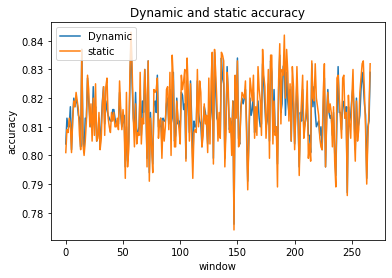

In [114]:
plt.plot(Dynmaic_model_acc)
plt.plot(static_model_acc)
plt.title('Dynamic and static accuracy')
plt.ylabel('accuracy')
plt.xlabel('window')
plt.legend(['Dynamic', 'static'], loc='upper left')
plt.show()

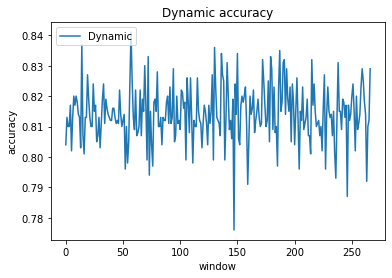

In [115]:
plt.plot(Dynmaic_model_acc)

plt.title('Dynamic accuracy')
plt.ylabel('accuracy')
plt.xlabel('window')
plt.legend(['Dynamic'], loc='upper left')
plt.show()

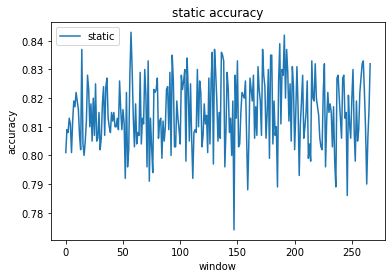

In [116]:

plt.plot(static_model_acc)
plt.title('static accuracy')
plt.ylabel('accuracy')
plt.xlabel('window')
plt.legend(['static'], loc='upper left')
plt.show()